In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import betterplotlib as bpl
from astropy import table

bpl.set_style()

# Load all the catalogs

In [2]:
def get_all_catalogs(catalog_prefix):
    tables = []
    data_dir = Path("../data").resolve()
    for galaxy_dir in data_dir.iterdir():
        size_dir = galaxy_dir / "size"
        for file in size_dir.iterdir():
            if catalog_prefix in file.name and file.suffix == ".h5":
                new_table = table.Table.read(file, format="hdf5")
                new_table["galaxy"] = galaxy_dir.name
                tables.append(new_table)
    return tables

In [3]:
bootstrap_tables = get_all_catalogs("radialweighting3pix_abs_bgscale1e3_thetascale1e1_noaprior_noqprior_bootstrapping")
jackknife_tables = get_all_catalogs("radialweighting3pix_abs_bgscale1e3_thetascale1e1_noaprior_noqprior_jackknife")

In [18]:
def unpad(padded_array):
    return padded_array[np.where(~np.isnan(padded_array))]


def pad(array, total_length):
    final_array = np.zeros(total_length) * np.nan
    final_array[: len(array)] = array
    return final_array

dist_cols = [
    "x_fitted",
    "y_fitted",
    "x_pix_snapshot_oversampled",
    "y_pix_snapshot_oversampled",
    "central_surface_brightness",
    "scale_radius_pixels",
    "axis_ratio",
    "position_angle",
    "power_law_slope",
    "local_background",
]
    
def format_tables(tables):
    for tab in tables:
        tab["r_eff_pixels_rmax_15pix_best"] = -99.9
        tab["r_eff_pixels_rmax_15pix_e+"] = -99.9
        tab["r_eff_pixels_rmax_15pix_e-"] = -99.9
        tab["r_eff_pixels_rmax_15pix_std"] = -99.9
        for col in dist_cols:
            tab[col] = [unpad(row[col]) for row in tab]
        
        tab["log_central_surface_brightness"] = [[np.log10(c) for c in unpad(row["central_surface_brightness"])] 
                                                 for row in tab]
        

In [5]:
format_tables(bootstrap_tables)
format_tables(jackknife_tables)

/Users/gillenb/miniconda3/envs/legus/lib/python3.8/site-packages/numpy/ma/core.py:2831: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _data = np.array(data, dtype=dtype, copy=copy,


In [6]:
bootstrap_table = table.vstack(bootstrap_tables, join_type="inner")
jackknife_table = table.vstack(jackknife_tables, join_type="inner")

## effective radius calculations

In [7]:
def logistic(eta):
    """
    This is the fit to the slopes as a function of eta

    These slopes are used in the ellipticity correction.
    :param eta: Eta (power law slope)
    :return: The slope to go in ellipticity_correction
    """
    ymax = 0.57902801
    scale = 0.2664717
    eta_0 = 0.92404378
    offset = 0.07298404
    return ymax / (1 + np.exp((eta_0 - eta) / scale)) - offset


def ellipticy_correction(q, eta):
    """
    Correction for ellipticity. This given R_eff(q) / R_eff(q=1)

    This is a generalized form of the simplified form used in Ryon's analysis. It's
    simply a line of arbitrary slope passing through (q=1, correction=1) as circular
    clusters need no correction. This lets us write the correction in point slope form
    as:
    y - 1 = m (q - 1)
    y = 1 + m (q - 1)

    Note that when m = 0.5, this simplifies to y = (1 + q) * 0.5, as used in Ryon.
    The slope here (m) is determined by fitting it as a function of eta.
    """
    return 1 + logistic(eta) * (q - 1)


def eff_profile_r_eff_with_rmax(eta, a, q, rmax):
    """
    Calculate the effective radius of an EFF profile, assuming a maximum radius.

    :param eta: Power law slope of the EFF profile
    :param a: Scale radius of the EFF profile, in any units.
    :param q: Axis ratio of the profile
    :param rmax: Maximum radius for the profile, in the same units as a.
    :return: Effective radius, in the same units as a and rmax
    """
    # This is such an ugly formula, put it in a few steps
    term_1 = 1 + (1 + (rmax / a) ** 2) ** (1 - eta)
    term_2 = (0.5 * (term_1)) ** (1 / (1 - eta)) - 1
    return ellipticy_correction(q, eta) * a * np.sqrt(term_2)

In [25]:
def add_reff(tab):
    tab["r_eff_pixels_rmax_15pix_best"] = eff_profile_r_eff_with_rmax(
        tab["power_law_slope_best"],
        tab["scale_radius_pixels_best"],
        tab["axis_ratio_best"],
        15,  # size of the box
    )

    # then go through it row by row to get the error distribution
    for row in tab:
        # Calculate the effective radius in pixels for all bootstrapping iterations
        all_r_eff_pixels = eff_profile_r_eff_with_rmax(
            row["power_law_slope"],
            row["scale_radius_pixels"],
            row["axis_ratio"],
            15,  # size of the box
        )
        # then get the 1 sigma error range of that
        lo, hi = np.percentile(all_r_eff_pixels, [15.85, 84.15])
        # subtract the middle to get the error range. If the best fit it outside the error
        # range, make the error in that direction zero.
        row["r_eff_pixels_rmax_15pix_e+"] = max(hi - row["r_eff_pixels_rmax_15pix_best"], 0)
        row["r_eff_pixels_rmax_15pix_e-"] = max(row["r_eff_pixels_rmax_15pix_best"] - lo, 0)
        
        row["r_eff_pixels_rmax_15pix_std"] = np.std(all_r_eff_pixels)

        
    # then ad fractional errors
    tab["fractional_error_hi"] = tab["r_eff_pixels_rmax_15pix_e+"] / tab["r_eff_pixels_rmax_15pix_best"]
    tab["fractional_error_lo"] = tab["r_eff_pixels_rmax_15pix_e-"] / tab["r_eff_pixels_rmax_15pix_best"]
    tab["fractional_error_percentile"] = np.mean([tab["fractional_error_hi"], tab["fractional_error_lo"]], axis=0)
    tab["fractional_error_std"] = tab["r_eff_pixels_rmax_15pix_std"] / tab["r_eff_pixels_rmax_15pix_best"]

In [26]:
add_reff(bootstrap_table)
add_reff(jackknife_table)

# Then do the analysis

Just do a simple histogram of errors

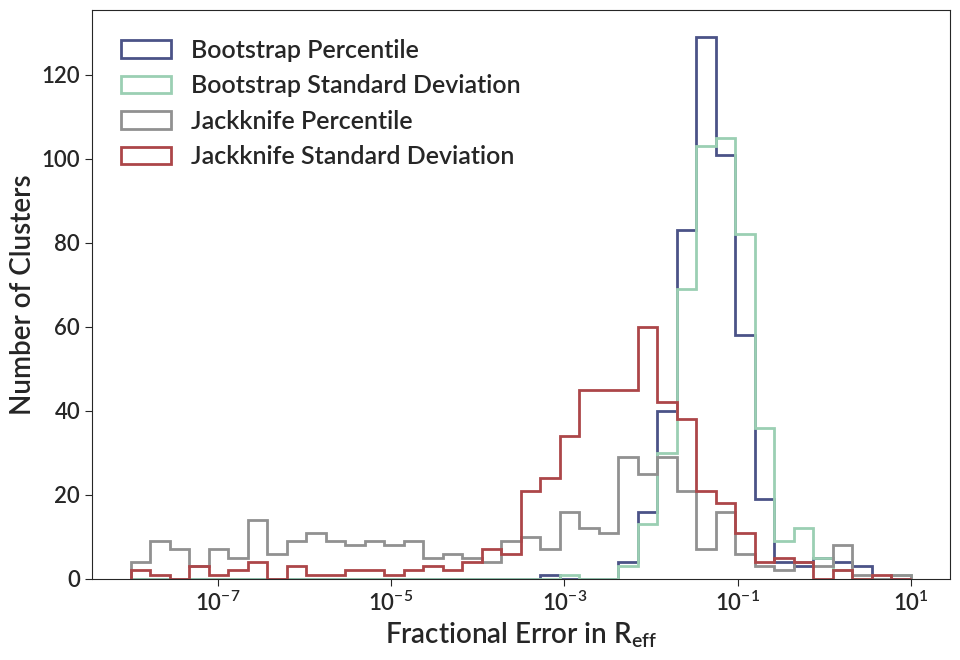

In [27]:
fig, ax = bpl.subplots()
bins = np.logspace(-8, 1, 41)
common = {"histtype": "step", "bins": bins, "lw": 2}
# ax.hist(bootstrap_table["fractional_error_hi"], **common, label="Bootstrap +")
# ax.hist(bootstrap_table["fractional_error_lo"], **common, label="Bootstrap -")
ax.hist(bootstrap_table["fractional_error_percentile"], **common, label="Bootstrap Percentile")
ax.hist(bootstrap_table["fractional_error_std"], **common, label="Bootstrap Standard Deviation")
# ax.hist(jackknife_table["fractional_error_hi"], **common, label="Jackknife +")
# ax.hist(jackknife_table["fractional_error_lo"], **common, label="Jackknife -")
ax.hist(jackknife_table["fractional_error_percentile"], **common, label="Jackknife Percentile")
ax.hist(jackknife_table["fractional_error_std"], **common, label="Jackknife Standard Deviation")


ax.set_xscale("log")
ax.legend(loc=2)
ax.add_labels("Fractional Error in $R_{eff}$", "Number of Clusters")
fig.savefig("jackknife_v_boostrap.png")

Cumulative version for Oleg

In [35]:
def make_cumulative_histogram(values):
    """
    Create the line to be plotted for a cumulative histogram

    :param values: data
    :return: List of xs and ys to be plotted for the cumulative histogram
    """
    sorted_values = np.sort(values)
    ys = np.arange(1, 1 + len(sorted_values), 1)
    assert len(ys) == len(sorted_values)
    return sorted_values, ys / np.max(ys)

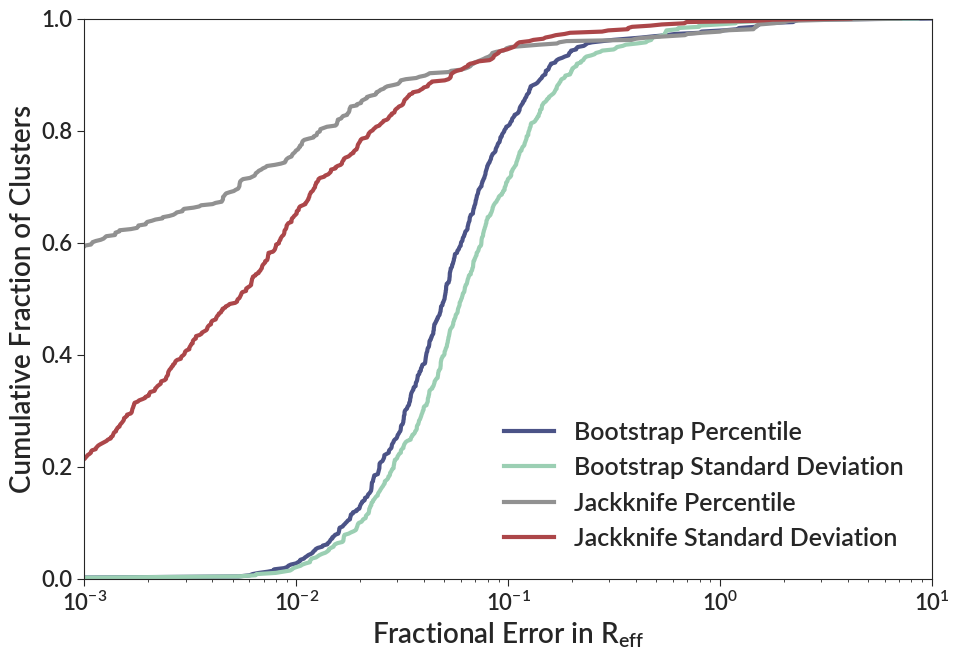

In [37]:
fig, ax = bpl.subplots()
bins = np.logspace(-8, 1, 41)

ax.plot(*make_cumulative_histogram(bootstrap_table["fractional_error_percentile"]), label="Bootstrap Percentile")
ax.plot(*make_cumulative_histogram(bootstrap_table["fractional_error_std"]), label="Bootstrap Standard Deviation")
ax.plot(*make_cumulative_histogram(jackknife_table["fractional_error_percentile"]), label="Jackknife Percentile")
ax.plot(*make_cumulative_histogram(jackknife_table["fractional_error_std"]), label="Jackknife Standard Deviation")

ax.set_xscale("log")
ax.legend(loc=4)
ax.add_labels("Fractional Error in $R_{eff}$", "Cumulative Fraction of Clusters")
ax.set_limits(1e-3, 10, 0, 1)
fig.savefig("jackknife_v_boostrap.png")

# This looks crazy. Check the parameters for one cluster

Find one where the errors are way different

In [17]:
mask_up = jackknife_table["fractional_error_hi"] < 1e-4
mask_dn = jackknife_table["fractional_error_hi"] > 1e-5

mask = np.logical_and(mask_up, mask_dn)

idx = np.where(mask)[0][0]

28.72117304032571 28.737198088946815
28.324410063533747 29.005281578216366

28.845623591188225 28.86886983633087
28.497011219976006 29.39439640091033

3.385325218477426 3.3906419649349164
3.2797734565054535 4.248079782970573

1.6062227523786885 1.6159761010791784
0.2996201307587227 1.748142658640234

0.7660285445595993 0.7731435501401847
0.5213803819807403 0.8551564063992141

1.2970587906733364 1.5494533204660996
0.05500661247277172 2.698658203437301

1.6738883456359122 1.6782251032603726
0.9680420385699279 1.9598934506510775

289910.7153969101 289910.95488018997
289845.73616019724 290120.5029723721



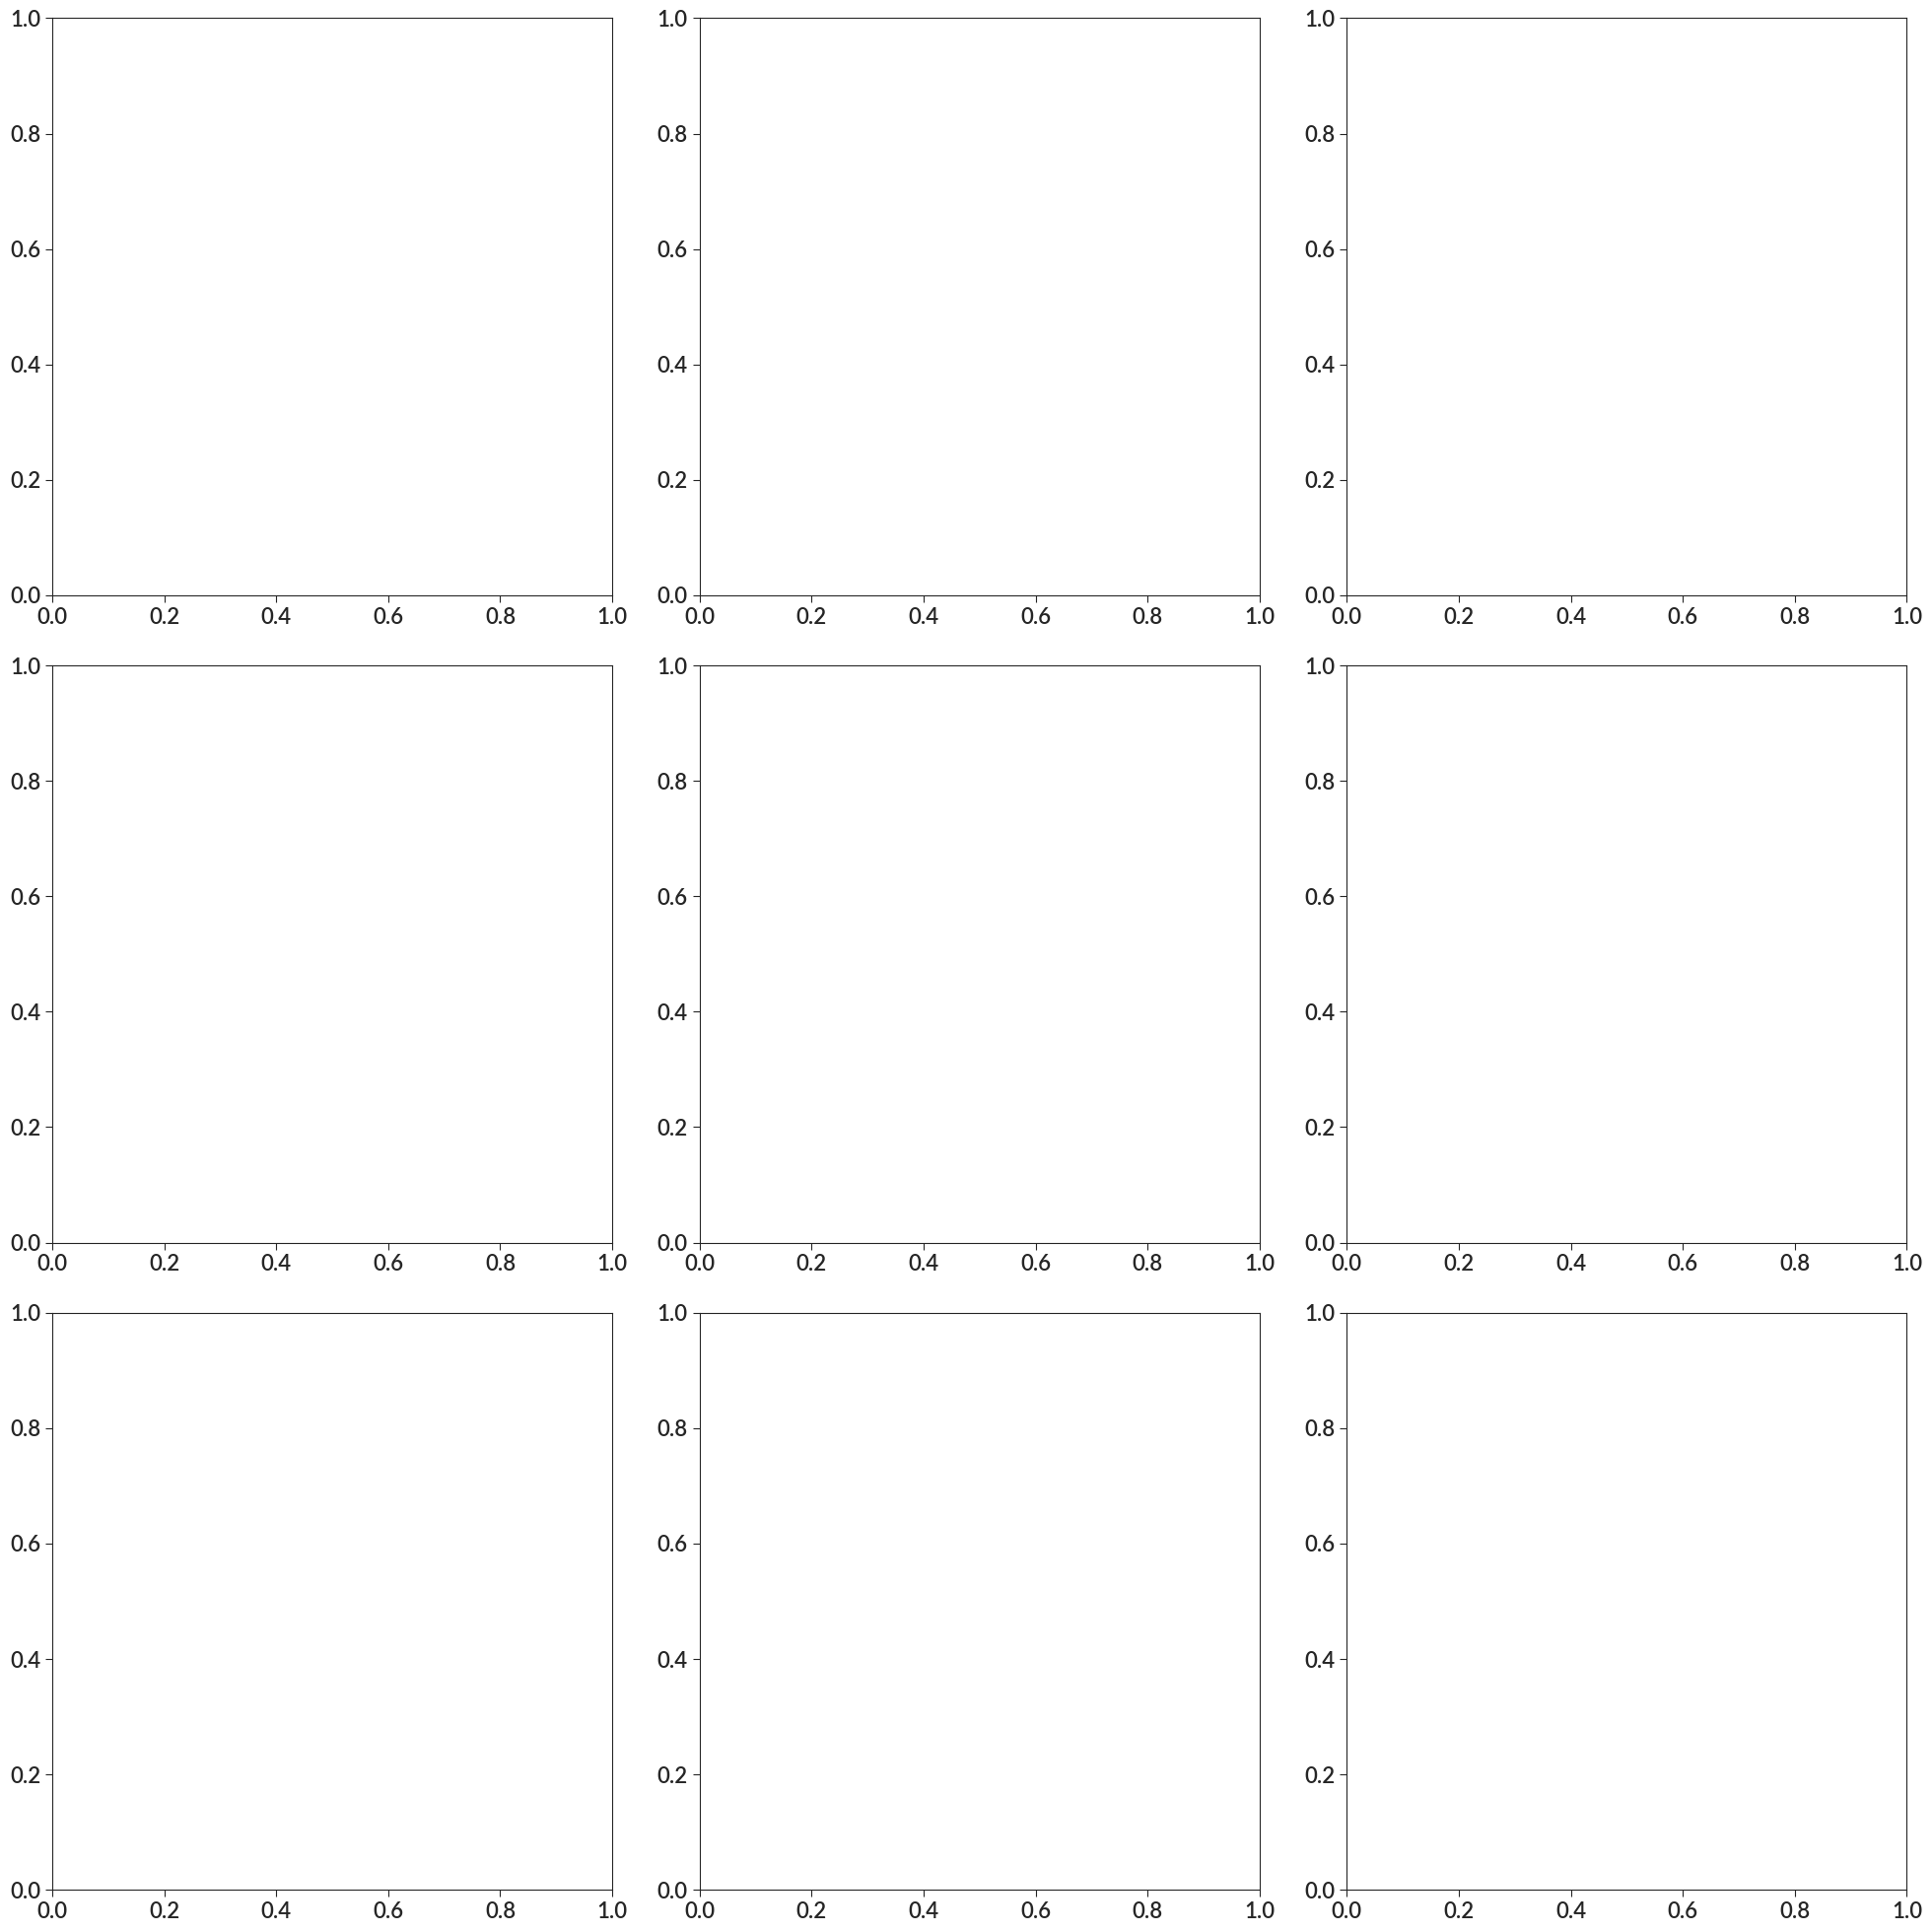

In [30]:
fig, axs = bpl.subplots(ncols=3, nrows=3, figsize=[20, 20])
axs = axs.flatten()

bin_sizes = {
    "x_pix_snapshot_oversampled":0.05,
    "y_pix_snapshot_oversampled":0.05,
    "log_central_surface_brightness": 0.05,
    "scale_radius_pixels":0.05,
    "axis_ratio":0.01,
    "position_angle":0.1,
    "power_law_slope":0.05,
    "local_background":10,
}
for ax, col in zip(axs, bin_sizes):
#     try:
#         ax.hist(jackknife_table[col][idx], label="Jackknife", histtype="step", bin_size=bin_sizes[col], rel_freq=True)
#     except:
#         ax.axvline(jackknife_table[col][idx][0])
    print(np.min(jackknife_table[col][idx]), np.max(jackknife_table[col][idx]))
    print(np.min(bootstrap_table[col][idx]), np.max(bootstrap_table[col][idx]))
    print()
#     ax.hist(bootstrap_table[col][idx], label="Bootstrap", histtype="step", bin_size=bin_sizes[col], rel_freq=True)
#     ax.add_labels(col, "Fraction of Iterations")

# Punchline - jackknife just does not produce a reasonable error distribution

This is probably because throwing out one pixel at a time does not change the fitted values much at all, especially if it's in the outskirts (which most pixels are). Bootstrapping will always throw out some pixels in the central region where the cluster is, so I think it's a better representation of what the actual errors on the fitting are. This is accentuated since we're measuring the spread by the percentile of the distribution, rather than the std. 